In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

sys.path.append("../Shared/")
from DataService import DataService

/tmp/ipykernel_654509/4293096832.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-06 13:21:03.602698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 13:21:04.105186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# fetch data from db

In [2]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [3]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [4]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [5]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [6]:
sm_df.drop(columns=["index", "cr_num", "month", "day"], inplace=True)
sm_df.head()
# sm_df.duplicated().sum() # 0
# print(sm_df.shape) #117221

,year,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1978,4612,0.165900,0.418710,0.237053
1,1978,4740,0.127140,0.207248,0.163722
2,1978,4741,0.153398,0.215304,0.170989
3,1978,4770,0.140772,0.186390,0.152211
4,1978,4771,0.116810,0.116810,0.116810


In [7]:
sm_df = sm_df.drop_duplicates()

In [8]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [9]:
ergot_df.shape

(1092, 13)

In [10]:
ergot_df.sample(5)

,year,district,percnt_true,has_ergot,sum_severity,present_prev1,present_prev2,present_prev3,present_in_neighbor,severity_prev1,severity_prev2,severity_prev3,severity_in_neighbor
308,2002,4771,0.000000,False,0.00,False,True,True,True,0.000000,0.02381,0.091603,0.010294
6,1995,4870,0.002016,True,4.00,False,False,False,False,0.000000,0.00000,0.000000,0.000000
610,2010,4733,0.000000,False,0.00,True,False,False,True,1.000000,0.00000,0.000000,0.010909
805,2015,4733,0.333333,True,0.01,False,False,False,True,0.000000,0.00000,0.000000,0.153285
449,2006,4720,0.000000,False,0.00,True,False,True,True,0.148649,0.00000,0.091837,0.029528


In [11]:
ergot_df["has_ergot"].value_counts()

True     881
False    211
Name: has_ergot, dtype: int64

In [12]:
ergot_df.drop(columns=["sum_severity", "present_in_neighbor", "severity_in_neighbor", "percnt_true"], inplace=True)

In [13]:
ergot_df.duplicated().sum()

0

In [14]:
ergot_df = ergot_df.drop_duplicates()

In [15]:
ergot_df.sample(5)

,year,district,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3
560,2009,4607,True,True,True,True,0.055556,0.065934,0.042017
954,2019,4710,True,True,True,True,0.417910,0.527473,0.414286
426,2005,4790,True,True,True,False,0.033333,0.110048,0.000000
916,2018,4711,True,True,True,True,0.308725,0.428571,0.436170
221,2000,4740,True,True,False,False,0.048780,0.000000,0.000000


In [16]:
ergot_df.shape

(1092, 9)

In [17]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

(1064, 5478)

In [18]:
weather_df

,Unnamed: 0,year,district,01-01:max_temp,01-01:min_temp,01-01:mean_temp,01-01:min_total_rain,01-01:max_total_rain,01-01:mean_total_rain,01-01:min_total_snow,...,12-31:mean_total_rain,12-31:min_total_snow,12-31:max_total_snow,12-31:mean_total_snow,12-31:min_total_precip,12-31:max_total_precip,12-31:mean_total_precip,12-31:min_snow_on_grnd,12-31:max_snow_on_grnd,12-31:mean_snow_on_grnd
0,0,1995,4860,-8.0375,-20.200000,-14.137500,0.0,0.0,0.0,0.0,...,0.0,0.0,7.3,1.70,0.0,1.5,0.444444,0.0,36.0,16.333333
1,1,1995,4810,-7.4200,-17.000000,-12.220000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,19.0,6.600000
2,2,1995,4840,-8.3000,-19.425000,-13.875000,0.0,0.0,0.0,0.0,...,0.0,0.0,2.9,1.52,0.0,7.7,2.280000,0.0,24.0,8.800000
3,3,1995,4830,-5.7500,-20.258333,-13.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,5.1,0.392308,0.0,28.0,5.615385
4,4,1995,4731,-7.3000,-19.650000,-13.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,1059,2022,4605,-28.3000,-33.000000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,27.0,27.0,27.000000
1060,1060,2022,4720,-24.8000,-36.900000,-30.850000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.1,0.050000,23.0,34.0,28.500000
1061,1061,2022,4611,-25.8000,-35.600000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.1,0.1,0.100000,14.0,14.0,14.000000
1062,1062,2022,4751,-22.9000,-33.600000,-28.300000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,6.0,6.0,6.000000


In [19]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [20]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    uni_col.add(all_col[i].split(":")[1])

In [21]:
uni_col

{'max_snow_on_grnd',
 'max_temp',
 'max_total_precip',
 'max_total_rain',
 'max_total_snow',
 'mean_snow_on_grnd',
 'mean_temp',
 'mean_total_precip',
 'mean_total_rain',
 'mean_total_snow',
 'min_snow_on_grnd',
 'min_temp',
 'min_total_precip',
 'min_total_rain',
 'min_total_snow'}

In [22]:
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    weather_df[col_name] = fil_col.mean(axis=1)
    weather_df.drop(columns=fil_col.columns, inplace=True)

In [23]:
weather_df

,year,district,max_total_snow,min_total_precip,max_total_precip,min_total_snow,max_snow_on_grnd,mean_temp,mean_total_rain,min_total_rain,mean_snow_on_grnd,mean_total_snow,mean_total_precip,min_snow_on_grnd,max_temp,min_temp,max_total_rain
0,1995,4860,1.438356,0.009589,4.561918,0.000000,14.356164,0.451735,0.529384,0.00000,6.005903,0.303979,1.189348,0.000000,6.238637,-5.342542,2.608767
1,1995,4810,0.416438,0.049589,2.528767,0.000000,2.334247,4.239744,0.328105,0.00000,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110
2,1995,4840,0.565479,0.064110,2.203836,0.000000,7.876712,1.628772,0.250507,0.00000,3.564932,0.155237,0.790694,0.175342,7.595941,-4.348895,1.018630
3,1995,4830,1.108219,0.001918,5.339178,0.000000,6.394521,3.060292,0.332711,0.00000,1.054999,0.135583,1.299196,0.000000,9.424064,-3.321827,2.089863
4,1995,4731,0.016438,0.618356,1.211233,0.005479,0.019178,2.796575,0.078265,0.00274,0.010959,0.010502,0.908037,0.002740,8.491324,-2.909954,0.157260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2022,4605,0.000000,1.151507,1.151507,0.000000,14.356164,0.777808,0.000000,0.00000,14.356164,0.000000,1.151507,14.356164,6.552603,-4.997808,0.000000
1060,2022,4720,0.000000,0.786027,1.409589,0.000000,8.556164,2.653288,0.000000,0.00000,6.519178,0.000000,1.097808,4.482192,9.157397,-3.850137,0.000000
1061,2022,4611,0.000000,2.099726,2.099726,0.000000,5.945205,1.931507,0.000000,0.00000,5.945205,0.000000,2.099726,5.945205,7.302466,-3.437808,0.000000
1062,2022,4751,0.000000,1.102466,1.102466,0.000000,5.210959,1.386849,0.000000,0.00000,5.210959,0.000000,1.102466,5.210959,6.706301,-3.926301,0.000000


In [24]:
df = pd.merge(ergot_df, weather_df,  on=["year", "district"], how="left")

In [25]:
df.isna().sum()

year                  0
district              0
has_ergot             0
present_prev1         0
present_prev2         0
present_prev3         0
severity_prev1        0
severity_prev2        0
severity_prev3        0
max_total_snow       28
min_total_precip     28
max_total_precip     28
min_total_snow       28
max_snow_on_grnd     28
mean_temp            28
mean_total_rain      28
min_total_rain       28
mean_snow_on_grnd    28
mean_total_snow      28
mean_total_precip    28
min_snow_on_grnd     28
max_temp             28
min_temp             28
max_total_rain       28
dtype: int64

In [26]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [27]:
df = pd.merge(df, sm_df, on=["year", "district"], how="left")

In [28]:
df.isna().sum()

year                   0
district               0
has_ergot              0
present_prev1          0
present_prev2          0
present_prev3          0
severity_prev1         0
severity_prev2         0
severity_prev3         0
max_total_snow         0
min_total_precip       0
max_total_precip       0
min_total_snow         0
max_snow_on_grnd       0
mean_temp              0
mean_total_rain        0
min_total_rain         0
mean_snow_on_grnd      0
mean_total_snow        0
mean_total_precip      0
min_snow_on_grnd       0
max_temp               0
min_temp               0
max_total_rain         0
soil_moisture_min     39
soil_moisture_max     39
soil_moisture_mean    39
dtype: int64

In [29]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [30]:
df.shape

(238545, 27)

In [31]:
# # joining tables
# # df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
# df = pd.merge(sm_df, ergot_df)

In [32]:
# df.shape

In [33]:
# df = pd.merge(df, weather_df, on=["year", "district"])

In [34]:
# df.shape

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238545 entries, 0 to 238544
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   year                238545 non-null  int64  
 1   district            238545 non-null  int64  
 2   has_ergot           238545 non-null  bool   
 3   present_prev1       238545 non-null  bool   
 4   present_prev2       238545 non-null  bool   
 5   present_prev3       238545 non-null  bool   
 6   severity_prev1      238545 non-null  float64
 7   severity_prev2      238545 non-null  float64
 8   severity_prev3      238545 non-null  float64
 9   max_total_snow      238545 non-null  float64
 10  min_total_precip    238545 non-null  float64
 11  max_total_precip    238545 non-null  float64
 12  min_total_snow      238545 non-null  float64
 13  max_snow_on_grnd    238545 non-null  float64
 14  mean_temp           238545 non-null  float64
 15  mean_total_rain     238545 non-nul

In [36]:
df

,year,district,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3,max_total_snow,...,mean_snow_on_grnd,mean_total_snow,mean_total_precip,min_snow_on_grnd,max_temp,min_temp,max_total_rain,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.416438,...,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110,0.142470,0.142470,0.142470
1,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.416438,...,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110,0.153655,0.153655,0.153655
2,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.416438,...,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110,0.136960,0.149358,0.142729
3,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.416438,...,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110,0.133652,0.142201,0.138300
4,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.416438,...,0.860822,0.116534,0.871078,0.000000,10.713096,-2.249689,1.224110,0.151432,0.151432,0.151432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238540,2022,4761,True,True,True,True,0.010204,0.076923,0.062893,0.000000,...,3.154566,0.000000,0.554178,0.068493,8.882808,-3.774612,0.000000,0.235296,0.281570,0.258433
238541,2022,4771,True,False,True,True,0.000000,0.153333,0.013072,0.000000,...,3.216438,0.000000,0.877260,3.216438,7.748219,-4.853699,0.000000,0.235296,0.281570,0.258433
238542,2022,4790,True,True,True,True,0.025316,0.229167,0.147727,0.185205,...,10.812785,0.030868,1.070091,0.961644,7.079132,-5.284676,0.517534,0.235296,0.281570,0.258433
238543,2022,4791,True,True,True,True,0.028986,0.223881,0.328571,0.000000,...,11.760959,0.000000,1.010822,0.000000,7.411553,-5.094840,0.000000,0.235296,0.281570,0.258433


In [37]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [38]:
# g = sns.pairplot(temp.sample(1000))

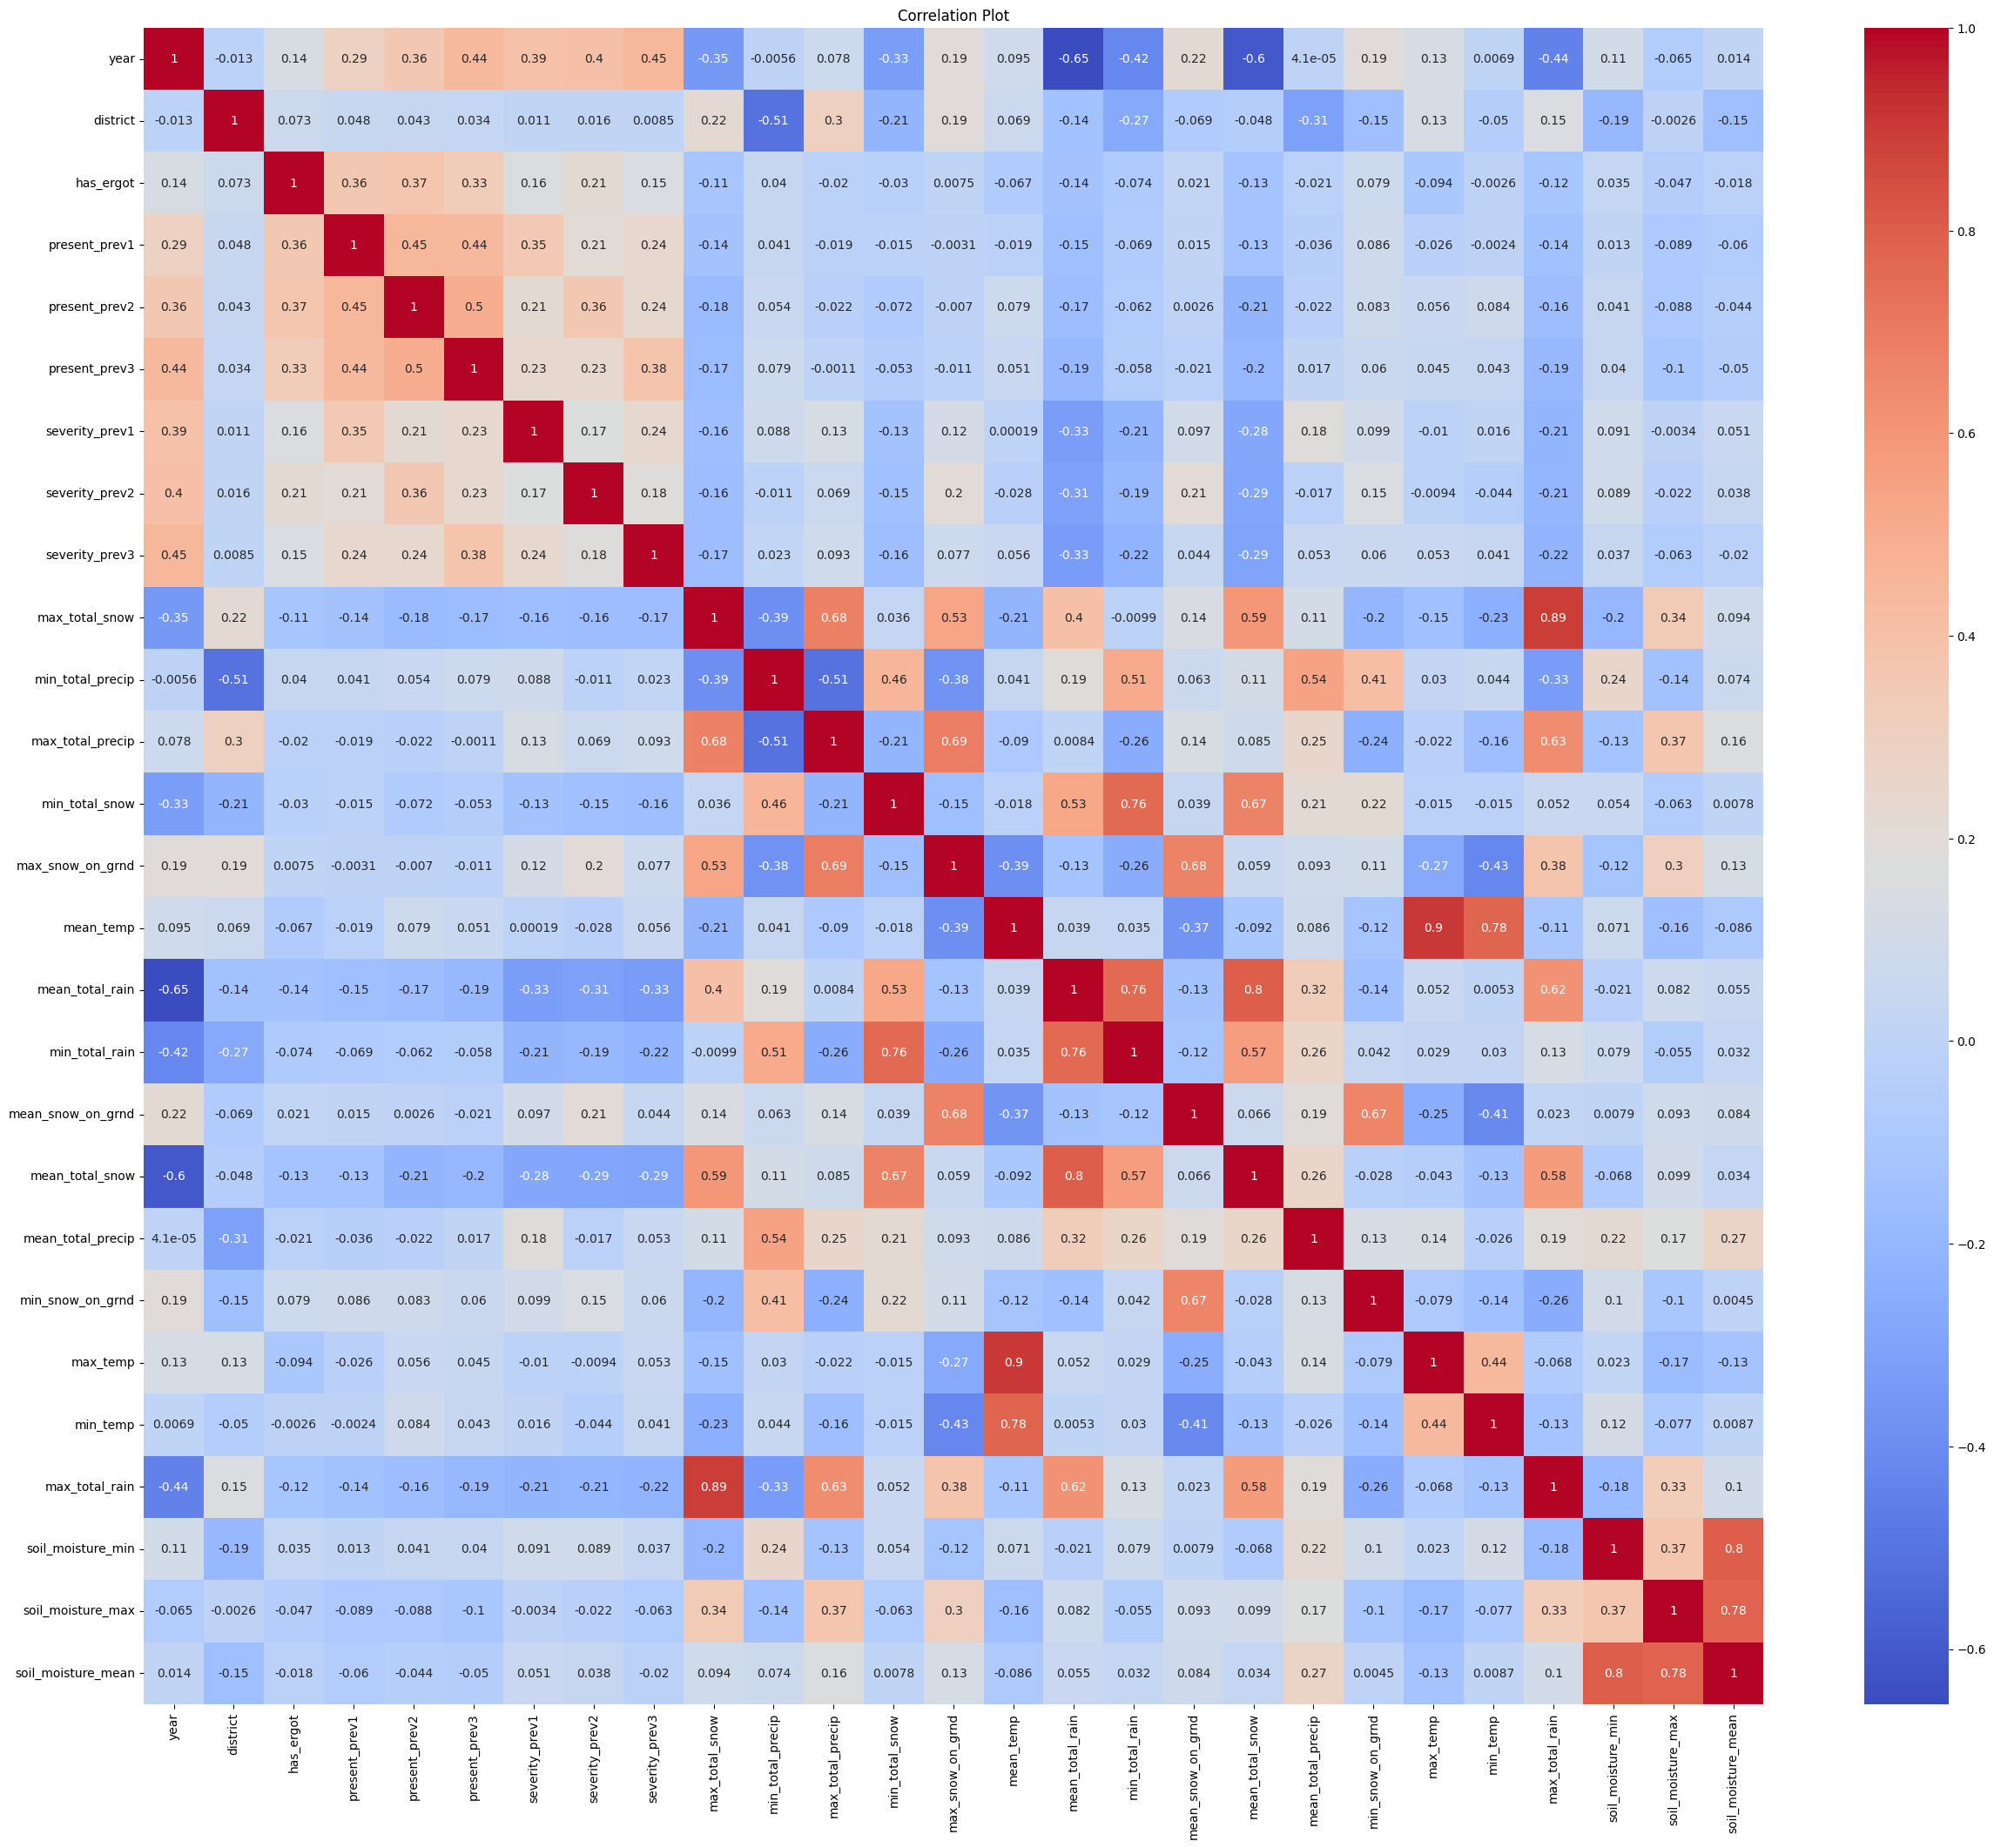

In [39]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [40]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [41]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

{'max_temp', 'max_total_rain'}

In [42]:
# df.drop(columns=corr_features, inplace=True)

In [43]:
# using one hot encoding to change catagorical variable to numarical
# df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [44]:
df.columns

Index(['year', 'district', 'has_ergot', 'present_prev1', 'present_prev2',
       'present_prev3', 'severity_prev1', 'severity_prev2', 'severity_prev3',
       'max_total_snow', 'min_total_precip', 'max_total_precip',
       'min_total_snow', 'max_snow_on_grnd', 'mean_temp', 'mean_total_rain',
       'min_total_rain', 'mean_snow_on_grnd', 'mean_total_snow',
       'mean_total_precip', 'min_snow_on_grnd', 'max_temp', 'min_temp',
       'max_total_rain', 'soil_moisture_min', 'soil_moisture_max',
       'soil_moisture_mean'],
      dtype='object')

# split data

In [45]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
oversampler = RandomOverSampler(random_state=42)
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
# print(y_train.value_count())
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [46]:
X_train.columns

Index(['year', 'district', 'present_prev1', 'present_prev2', 'present_prev3',
       'severity_prev1', 'severity_prev2', 'severity_prev3', 'max_total_snow',
       'min_total_precip', 'max_total_precip', 'min_total_snow',
       'max_snow_on_grnd', 'mean_temp', 'mean_total_rain', 'min_total_rain',
       'mean_snow_on_grnd', 'mean_total_snow', 'mean_total_precip',
       'min_snow_on_grnd', 'max_temp', 'min_temp', 'max_total_rain',
       'soil_moisture_min', 'soil_moisture_max', 'soil_moisture_mean'],
      dtype='object')

In [47]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
X_train_scaled.shape

(190836, 26)

In [49]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


2023-07-06 13:22:58.664242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-06 13:22:58.695398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-06 13:22:58.695693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# creating model

In [50]:
model = Sequential()

model.add(Dense(15, activation="relu", input_dim = X.shape[1]))
# model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(1, activation="sigmoid", input_dim = X.shape[1]))

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                405       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [52]:
# compile model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [54]:
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/100
   1/4771 [..............................] - ETA: 22s - loss: 0.3732 - accuracy: 0.8750

4771/4771 [==============================] - 5s 947us/step - loss: 0.2653 - accuracy: 0.8844 - val_loss: 0.2444 - val_accuracy: 0.8974
Epoch 2/100
4771/4771 [==============================] - 4s 897us/step - loss: 0.2306 - accuracy: 0.9048 - val_loss: 0.2168 - val_accuracy: 0.9125
Epoch 3/100
4771/4771 [==============================] - 4s 913us/step - loss: 0.2065 - accuracy: 0.9167 - val_loss: 0.1961 - val_accuracy: 0.9207
Epoch 4/100
4771/4771 [==============================] - 4s 898us/step - loss: 0.1880 - accuracy: 0.9260 - val_loss: 0.1815 - val_accuracy: 0.9253
Epoch 5/100
4771/4771 [==============================] - 4s 879us/step - loss: 0.1757 - accuracy: 0.9311 - val_loss: 0.1705 - val_accuracy: 0.9347
Epoch 6/100
4771/4771 [==============================] - 4s 909us/step - loss: 0.1656 - accuracy: 0.9358 - val_loss: 0.1614 - val_accuracy: 0.9402
Epoch 7/100
4771/4771 [==============================] - 4s 883us/step - loss: 0.1574 - accuracy: 0.9397 - val_loss: 0.1535 - val_

In [55]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(26, 15) dtype=float32, numpy=
 array([[-2.55963469e+00,  1.19820368e+00, -2.40102863e+00,
         -1.21066833e+00,  3.48724866e+00, -4.29337931e+00,
          4.21136093e+00, -5.39253652e-01, -4.19150639e+00,
         -2.07036090e+00,  2.70201266e-01, -3.24013638e+00,
          1.78174770e+00, -6.38196111e-01,  1.72891572e-01],
        [ 2.00870991e+00,  2.10780740e+00,  1.86550111e-01,
         -3.53455693e-01,  2.64763427e+00, -8.42254817e-01,
          3.31733036e+00, -4.32481337e+00, -1.60701323e+00,
          3.24564767e+00, -2.58923006e+00,  1.94135755e-01,
         -1.61489224e+00, -1.29857075e+00, -1.89500308e+00],
        [-2.97276676e-01, -4.52682152e-02,  1.03600597e+00,
          3.40520406e+00,  4.26156282e-01, -2.17620075e-01,
          1.83045781e+00, -2.12022141e-01,  7.03051463e-02,
          1.49418461e+00,  2.96498179e-01,  3.63951117e-01,
         -6.99462831e-01,  3.60733479e-01,  4.58281845e-01],
        [ 1.23954976e+00,  6.

In [56]:
y_pred = model.predict(X_test_scaled)

   1/1491 [..............................] - ETA: 1:03

1491/1491 [==============================] - 1s 452us/step


In [57]:
threshhold = 0.8
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [58]:
accuracy_score(y_test, y_pred)

0.9970865035947096

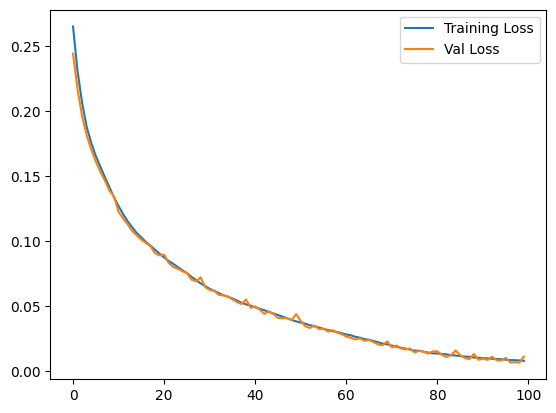

In [59]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

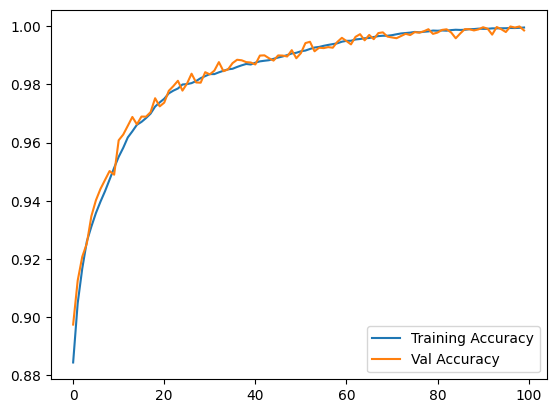

In [60]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      9661
        True       1.00      1.00      1.00     38048

    accuracy                           1.00     47709
   macro avg       0.99      1.00      1.00     47709
weighted avg       1.00      1.00      1.00     47709



0.996628832704111


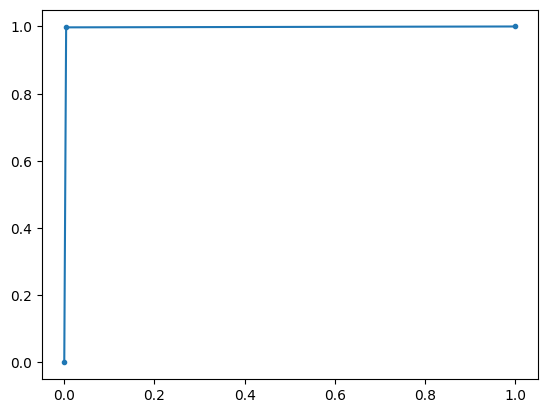

In [62]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".")
print(auc_)

In [63]:
# prints weight with attribute
attributes = X_train.columns.tolist()
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

result = {}

for x, y in zip(attributes, weights):
    result[x] = y

result = pd.DataFrame(result)

result.transpose()
print(result.max())

year                  4.211361
district              3.317330
present_prev1         3.405204
present_prev2         3.368348
present_prev3         2.380444
severity_prev1        3.614282
severity_prev2        3.683248
severity_prev3        3.469473
max_total_snow        3.061461
min_total_precip      3.810125
max_total_precip      2.190224
min_total_snow        1.658278
max_snow_on_grnd      2.367798
mean_temp             0.776144
mean_total_rain       3.240674
min_total_rain        3.243279
mean_snow_on_grnd     5.151693
mean_total_snow       2.243233
mean_total_precip     2.283566
min_snow_on_grnd      5.160485
max_temp              1.849234
min_temp              3.099436
max_total_rain        2.199089
soil_moisture_min     0.057340
soil_moisture_max     0.046151
soil_moisture_mean    0.078248
dtype: float32
